In [1]:
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from mlresearch.utils import set_matplotlib_style
from recgame.environments import BaseEnvironment
from recgame.recourse import DiCE

set_matplotlib_style(16)

# Some variables to define the problem
BIAS_FACTOR = 0
RNG_SEED = 43
rng = np.random.default_rng(RNG_SEED)
N_CONTINUOUS = 2
N_AGENTS = 100

# NOTE: Categorical feature will be the "groups" variable; immutable + categorical

# Environment variables
N_LOANS = 10
ADAPTATION = .3
NEW_AGENTS = 10

# Define functions

In [2]:
def biased_data_generator(n_agents, n_continuous=2, bias_factor=0, random_state=None):
    """
    groups feature: 
    - 0 -> Disadvantaged group
    - 1 -> Advantaged group
    
    ``bias_factor`` varies between [0, 1], 0 is completely unbiased, 1 is fully biased.
    """
    rng = np.random.default_rng(random_state)
    groups = pd.Series(rng.binomial(1,.5, n_agents), name="groups")
    counts = Counter(groups)
    continuous_cols = [f"f{i}" for i in range(n_continuous)]

    # Generate the input dataset
    X_0 = pd.DataFrame(
        rng.normal(loc=0, scale=2, size=(counts[0], n_continuous)),
        index=groups[groups == 0].index,
        columns=continuous_cols,
    )

    X_1 = pd.DataFrame(
        rng.normal(loc=bias_factor, scale=2, size=(counts[1], n_continuous)),
        index=groups[groups == 1].index,
        columns=continuous_cols,
    )

    X = pd.concat([X_0, X_1]).sort_index()
    X = pd.concat([X, groups], axis=1)
    
    # Generate the target
    p1 = 0.5 * bias_factor + 0.5
    p0 = 1 - p1

    y0 = rng.binomial(1, p0, counts[0])
    y1 = rng.binomial(1, p1, counts[1])
    
    y = pd.concat(
        [
            pd.Series((y0 if val==0 else y1), index=group.index) 
            for val, group in X.groupby("groups")
        ]
    ).sort_index()

    return X, y

def env_biased_data_generator(n_agents):
    return biased_data_generator(n_agents, N_CONTINUOUS, BIAS_FACTOR, rng)[0]

# Experiments

In [3]:
df, y = biased_data_generator(N_AGENTS, N_CONTINUOUS, BIAS_FACTOR, rng)
categorical = ["groups"]

# model = RandomForestClassifier().fit(df, y)
model = LogisticRegression().fit(df, y)
df.groupby([y, "groups"]).size(), df.groupby([model.predict(df), "groups"]).size()

(   groups
 0  0         21
    1         23
 1  0         27
    1         29
 dtype: int64,
    groups
 1  0         48
    1         52
 dtype: int64)

In [4]:
# Define the necessary components to run simulation
recourse = DiCE(model, categorical=["groups"], immutable=["groups"]) 
# NOTE: setting a random state was forcing the algorithm to fail...

environment = BaseEnvironment(
    X=df,
    recourse=recourse,
    data_source_func=env_biased_data_generator,
    threshold=N_LOANS,
    threshold_type="absolute",
    adaptation=ADAPTATION,
    behavior_function="continuous_flexible",
    growth_rate=NEW_AGENTS,
    growth_rate_type="absolute",
    random_state=RNG_SEED,
)

environment.simulate(10)

/home/joaofonseca/miniconda3/envs/recourse-game/lib/python3.10/site-packages/dice_ml/utils/exception.py:12: UserWarning: UserConfigValidationException will be deprecated from dice_ml.utils. Please import UserConfigValidationException from raiutils.exceptions.
  warnings.warn("UserConfigValidationException will be deprecated from dice_ml.utils. "
 16%|█▊          | 14/90 [00:00<00:05, 14.19it/s]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 98%|███████████▋| 88/90 [00:06<00:00, 14.39it/s]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 49%|█████▊      | 44/90 [00:03<00:03, 13.09it/s]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


100%|████████████| 90/90 [00:06<00:00, 13.48it/s]


BaseEnvironment(X=          f0        f1  groups
0  -0.564250  1.630281       1
1  -4.715033 -1.040726       0
2   1.576533 -0.529321       0
3   1.355048 -3.100245       1
4   0.132097 -2.803462       1
..       ...       ...     ...
95  0.862265  1.679218       1
96  0.241516  2.290077       1
97  3.102327  1.095026       0
98 -1.534306 -0.406877       1
99  1.239031 -1.560062       1

[100 rows x 3 columns],
                adaptation=0.3,
                data_source_func=<function env_biased_data_generator at 0x7fce1c0e80d0>,
                growth_rate=10, growth_rate_type='absolute', random_state=43,
                recourse=DiCE(categorical=['groups'], immutable=['groups'],
                              model=LogisticRegression(),
                              threshold=0.5982292065016391),
                threshold=10)

# Visualization and analysis

In [5]:
from matplotlib.colors import ListedColormap
environment.plot._favorable = ListedColormap(["#40b27f", "green"])
environment.plot._unfavorable = ListedColormap(["#51a3ef", "blue"])
environment.plot._previous = ListedColormap(["#be4d65", "red"])

/home/joaofonseca/miniconda3/envs/recourse-game/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


<Axes: title={'center': 'Population scores over 11 time steps'}, xlabel='Step', ylabel='Score'>

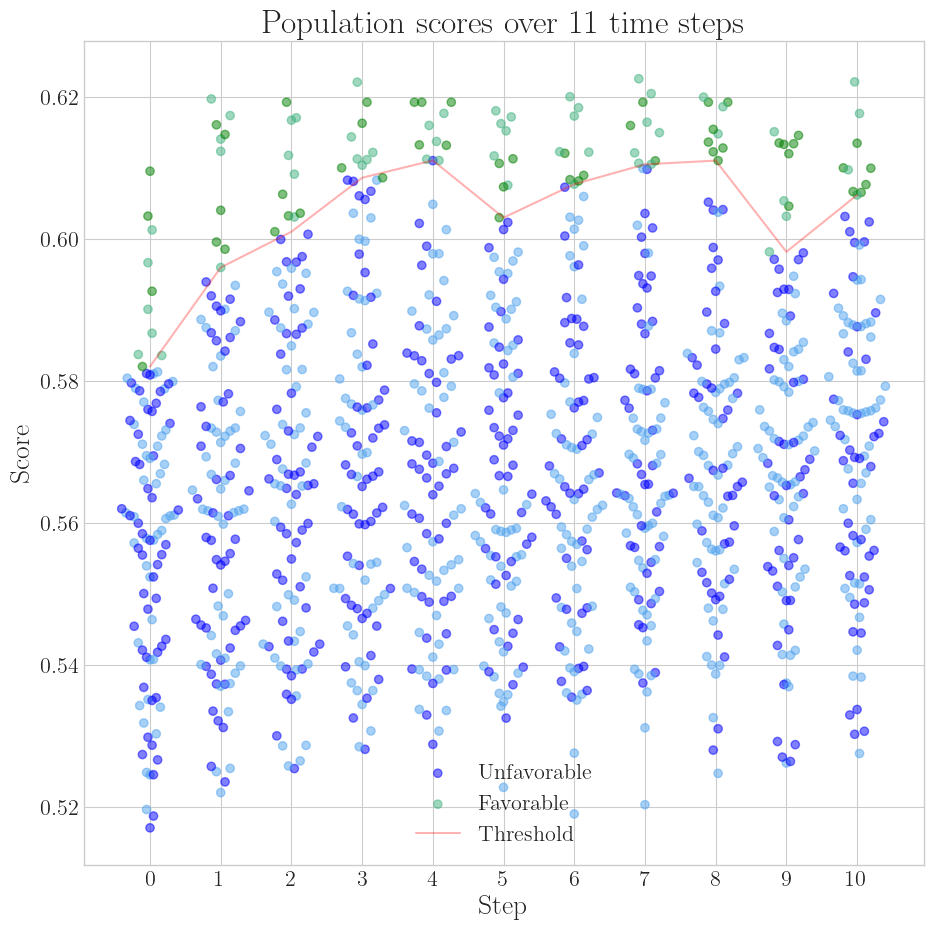

In [6]:
environment.plot.agent_scores(color_feature="groups")

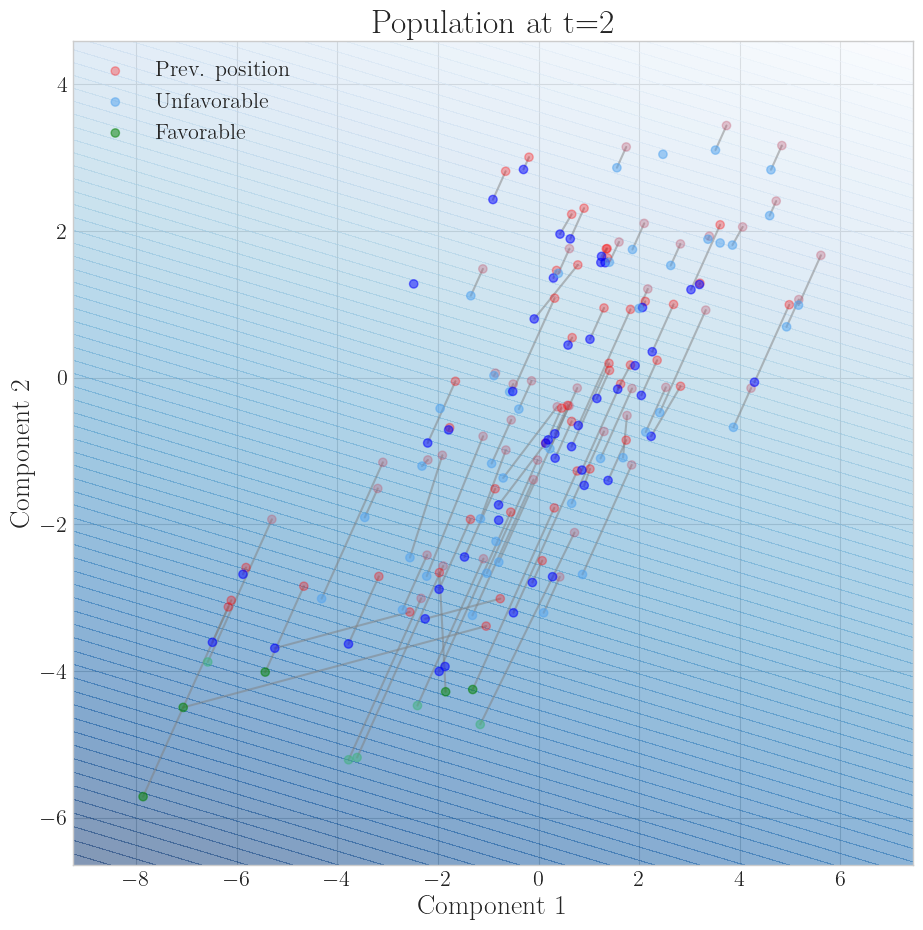

In [7]:
ax = environment.plot.scatter(2, color_feature="groups")

In [8]:
environment.analysis.agents_info()

,entered_step,n_adaptations,favorable_step,original_score,final_score,n_failures
0,0,2,2.0,0.572511,0.603303,0
1,0,10,NaN,0.543111,NaN,0
2,0,5,5.0,0.560626,0.618112,0
3,0,10,NaN,0.526616,NaN,0
4,0,10,NaN,0.527371,NaN,0
...,...,...,...,...,...,...
195,10,0,NaN,0.584121,NaN,0
196,10,0,NaN,0.570294,NaN,0
197,10,0,NaN,0.559113,NaN,0
198,10,0,NaN,0.548757,NaN,0


In [9]:
environment.analysis.steps_info()

,n_adapted,n_candidates,favorable_outcomes,success_rate,threshold,threshold_drift,new_agents,new_agents_proba,moving_agent_proba,success_proba
1,90.0,24.0,10.0,0.416667,0.596027,0.023985,10.0,0.04,0.272719,1.466252e-06
2,90.0,14.0,10.0,0.714286,0.601070,0.008460,10.0,0.03,0.271842,7.670354e-07
3,90.0,18.0,10.0,0.555556,0.608674,0.012651,10.0,0.01,0.220500,8.962556e-05
4,90.0,11.0,10.0,0.909091,0.611113,0.004007,10.0,0.00,0.167783,2.307043e-02
5,90.0,6.0,10.0,1.000000,0.603050,-0.013193,10.0,0.02,0.247116,1.626117e-05
6,90.0,13.0,10.0,0.769231,0.607766,0.007820,10.0,0.01,0.200064,1.451785e-03
7,90.0,12.0,10.0,0.833333,0.610564,0.004604,10.0,0.00,0.173774,1.279062e-02
8,90.0,10.0,10.0,1.000000,0.611093,0.000867,10.0,0.00,0.161512,3.858253e-02
9,90.0,6.0,10.0,1.000000,0.598229,-0.021050,10.0,0.03,0.320027,1.490328e-08
10,90.0,15.0,10.0,0.666667,0.606247,0.013402,10.0,0.01,0.251207,4.211671e-05


In [10]:
filter_feature = "groups"

In [11]:
groups = pd.concat([environment.metadata_[step]["X"][filter_feature] for step in environment.metadata_.keys()])
groups = groups[~groups.index.duplicated(keep='last')].sort_index()
agents_info = environment.analysis.agents_info()
agents_info = pd.concat([agents_info, groups], axis=1)
agents_info = agents_info.dropna()
agents_info["time_for_recourse"] = agents_info["favorable_step"] - agents_info["entered_step"]
fairness_analysis = agents_info.groupby(filter_feature).mean()

In [12]:
success_rates = environment.analysis.success_rate(filter_feature=filter_feature)
fairness_analysis["avg_recourse_reliability"] = success_rates.mean()

In [17]:
BIAS_FACTOR

0

In [13]:
fairness_analysis[["n_failures", "time_for_recourse", "avg_recourse_reliability"]]

,n_failures,time_for_recourse,avg_recourse_reliability
groups,,,
0,0.192982,3.298246,0.879167
1,0.396226,4.433962,0.728593


# Draft code

In [14]:
BIAS_FACTOR

0

In [15]:
df

,f0,f1,groups
0,-0.564250,1.630281,1
1,-4.715033,-1.040726,0
2,1.576533,-0.529321,0
3,1.355048,-3.100245,1
4,0.132097,-2.803462,1
...,...,...,...
95,0.862265,1.679218,1
96,0.241516,2.290077,1
97,3.102327,1.095026,0
98,-1.534306,-0.406877,1


In [16]:
counts = Counter(df["groups"])